In [7]:
from pedpy import load_trajectory
from pedpy import (
    Geometry,
    TrajectoryUnit,
    get_invalid_trajectory,
    is_trajectory_valid,
)
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
from shapely import LineString, Polygon
import warnings

warnings.filterwarnings("ignore")
from playsound import playsound
import time

In [2]:
from shapely import Polygon

# Setup geometry & measurement area

## Prepare geometry

![](../demos/uni-directional/geo.png)

In [3]:
geometry_poly = Polygon([(-10, -3), (-10, 8), (10, 8), (10, -3)])

geometry = Geometry(walkable_area=geometry_poly)
geometry.add_obstacle(Polygon([(-9, -2), (-9, 0), (9, 0), (9, -2), (-9, -2)]))
geometry.add_obstacle(Polygon([(-9, 5), (-9, 7), (9, 7), (9, 5), (-9, 5)]))

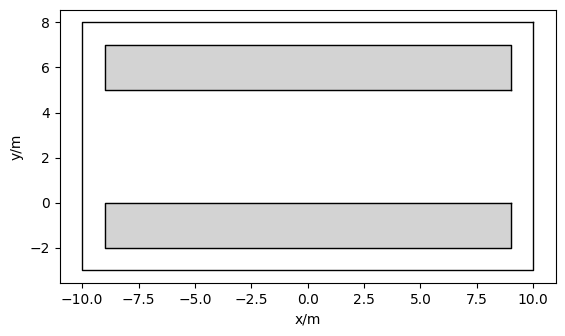

In [5]:
from pedpy.plotting.plotting import plot_geometry

plot_geometry(geometry=geometry, hole_color="lightgrey").set_aspect("equal")

playsound("sound.mp3")

**For demonstration purposes, wrongly place the obstacle s.th. some pedestrian walk through it!**

In [4]:
geometry_faulty = Geometry(walkable_area=geometry_poly)
geometry_faulty.add_obstacle(
    Polygon([(-9, -2), (-9, 0.25), (9, 0.25), (9, -2), (-9, -2)])
)
geometry_faulty.add_obstacle(
    Polygon([(-9, 5), (-9, 7), (9, 7), (9, 5), (-9, 5)])
)

In [8]:
time.sleep(3) # Sleep for 3 seconds
playsound("sound.mp3")


## Prepare measurement details

In [5]:
ma = Polygon([(-1.5, 0), (-1.5, 5), (1.5, 5), (1.5, 0), (-1.5, 0)])
ml = LineString([(0, 0), (0, 5)])
passing_offset = 1.0

direction = np.array([-1, 0])

## Load trajectories

`pedpy` can load trajectories from text files, when:
- values are seperated by any whitespace, e.g., space, tab
- file has at least 5 columns in the following order: "ID", "frame", "X", "Y", "Z"
- file may contain comment lines with `#` at in the beginning

For meaningful analysis (and loading of the trajectory file) you also need
- unit of the trajectory (m or cm)
- frame rate

For recent experiments they are encoded in the header of the file, for older you may need to lead the documentation and provide the information in the loading process!

**Examples:**
With frame rate, but no unit
```
# description: UNI_CORR_500_01
# framerate: 25.00
#geometry: geometry.xml

# PersID	Frame	X	Y	Z
1	98	4.6012	1.8909	1.7600
1	99	4.5359	1.8976	1.7600
1	100	4.4470	1.9304	1.7600
...
```

No header at all:
```
1 27 164.834 780.844 168.937
1 28 164.835 771.893 168.937
1 29 163.736 762.665 168.937
1 30 161.967 753.088 168.937
...
```

In [6]:
traj = load_trajectory(
    trajectory_file=pathlib.Path(
        "../demos/uni-directional/traj_UNI_CORR_500_01.txt"
    ),
    default_unit=TrajectoryUnit.METER,  # needs to be provided as it not defined in the file
    # default_frame_rate=25., # can be ignored here as the frame rate is defined in the file
)

## Plot setup

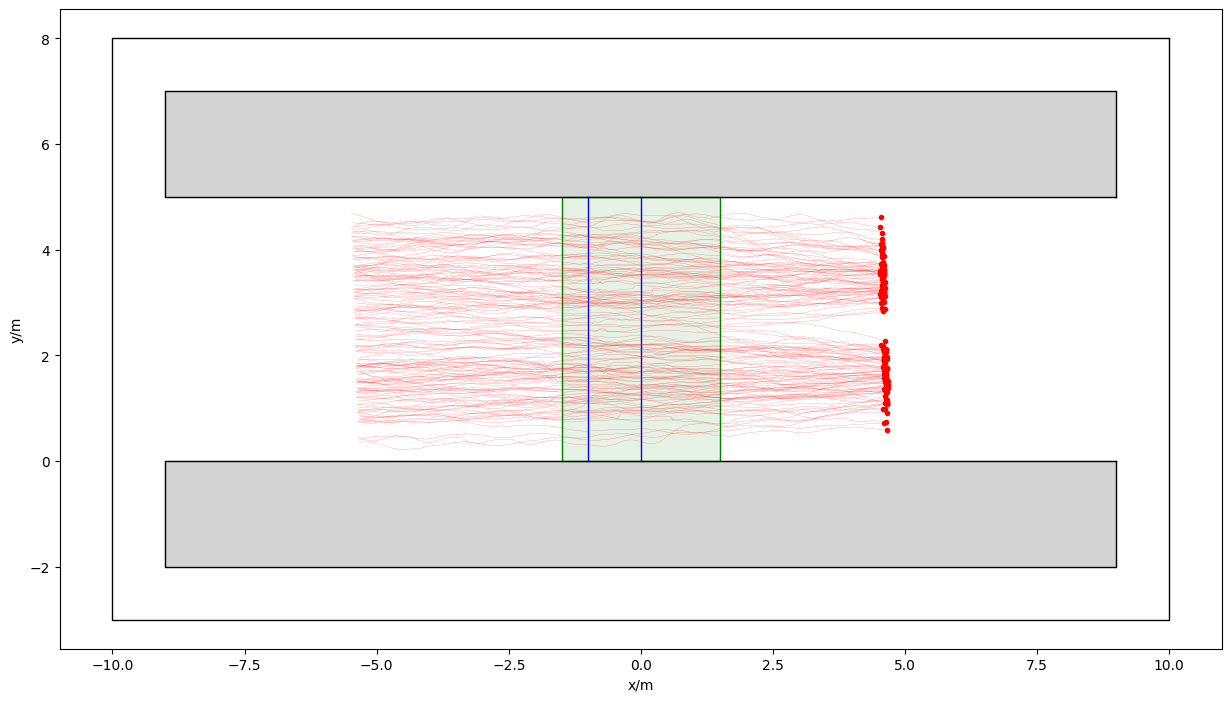

In [7]:
from pedpy import plot_measurement_setup

fig = plt.figure(figsize=(15, 20))
ax1 = fig.add_subplot(111, aspect="equal")
# ax1 = plot_geometry(geometry=geometry_faulty, ax=ax1) # remove comment to show the borders of the faulty geometry

plot_measurement_setup(
    traj=traj,
    geometry=geometry,
    measurement_areas=[ma],
    measurement_lines=[ml, shapely.offset_curve(ml, passing_offset)],
    traj_width=0.1,
    traj_start_marker=".",
    hole_color="lightgrey",
    ml_color="b",
    ma_color="g",
    ma_alpha=0.1,
    ma_line_color="g",
    ax=ax1,
)
plt.show()

## Validate that trajectory is completely inside the walkable area.

In [8]:
print(
    f"Trajectory is valid: {is_trajectory_valid(traj=traj, geometry=geometry)}"
)
get_invalid_trajectory(traj=traj, geometry=geometry)

Trajectory is valid: True


,ID,frame,X,Y,Z,points


In [9]:
print(
    f"Trajectory is valid: {is_trajectory_valid(traj=traj, geometry=geometry_faulty)}"
)
get_invalid_trajectory(traj=traj, geometry=geometry_faulty)

Trajectory is valid: False


,ID,frame,X,Y,Z,points
1665,10,274,-4.1773,0.2422,1.76,POINT (-4.1773 0.2422)
1666,10,275,-4.2469,0.2441,1.76,POINT (-4.2469 0.2441)
1667,10,276,-4.3337,0.2347,1.76,POINT (-4.3337 0.2347)
1668,10,277,-4.4124,0.2265,1.76,POINT (-4.4124 0.2265)
1669,10,278,-4.4921,0.2186,1.76,POINT (-4.4921 0.2186)
1670,10,279,-4.5609,0.2190,1.76,POINT (-4.5609 0.219)
1671,10,280,-4.6374,0.2444,1.76,POINT (-4.6374 0.2444)
1672,10,281,-4.6769,0.2392,1.76,POINT (-4.6769 0.2392)


# Filter the trajectory data

## Filter by geometrical predicates

### Data inside Polygon

In [10]:
data_inside_ma = traj.data[shapely.within(traj.data.points, ma)]
data_inside_ma

,ID,frame,X,Y,Z,points
53,1,151,1.4782,1.9126,1.76,POINT (1.4782 1.9126)
54,1,152,1.4269,1.9207,1.76,POINT (1.4269 1.9207)
55,1,153,1.3689,1.9295,1.76,POINT (1.3689 1.9295)
56,1,154,1.3109,1.9383,1.76,POINT (1.3109 1.9383)
57,1,155,1.2557,1.9419,1.76,POINT (1.2557 1.9419)
...,...,...,...,...,...,...
25458,148,799,-1.2681,1.3531,1.76,POINT (-1.2681 1.3531)
25459,148,800,-1.3238,1.3537,1.76,POINT (-1.3238 1.3537)
25460,148,801,-1.3794,1.3526,1.76,POINT (-1.3794 1.3526)
25461,148,802,-1.4372,1.3474,1.76,POINT (-1.4372 1.3474)


### Data outside Polygon

In [11]:
data_outside_ma = traj.data[~shapely.within(traj.data.points, ma)]
data_outside_ma

,ID,frame,X,Y,Z,points
0,1,98,4.6012,1.8909,1.76,POINT (4.6012 1.8909)
1,1,99,4.5359,1.8976,1.76,POINT (4.5359 1.8976)
2,1,100,4.4470,1.9304,1.76,POINT (4.447 1.9304)
3,1,101,4.3865,1.9364,1.76,POINT (4.3865 1.9364)
4,1,102,4.3285,1.9452,1.76,POINT (4.3285 1.9452)
...,...,...,...,...,...,...
25531,148,872,-5.1631,1.4840,1.76,POINT (-5.1631 1.484)
25532,148,873,-5.2162,1.4826,1.76,POINT (-5.2162 1.4826)
25533,148,874,-5.2685,1.4796,1.76,POINT (-5.2685 1.4796)
25534,148,875,-5.3164,1.4793,1.76,POINT (-5.3164 1.4793)


### Data close to Polygon

In [12]:
data_close_ma = traj.data[shapely.dwithin(traj.data.points, ma, 1)]
data_close_ma

,ID,frame,X,Y,Z,points
35,1,133,2.4849,1.9757,1.76,POINT (2.4849 1.9757)
36,1,134,2.4299,1.9741,1.76,POINT (2.4299 1.9741)
37,1,135,2.3722,1.9724,1.76,POINT (2.3722 1.9724)
38,1,136,2.3147,1.9681,1.76,POINT (2.3147 1.9681)
39,1,137,2.2572,1.9611,1.76,POINT (2.2572 1.9611)
...,...,...,...,...,...,...
25476,148,817,-2.2507,1.3925,1.76,POINT (-2.2507 1.3925)
25477,148,818,-2.3050,1.3999,1.76,POINT (-2.305 1.3999)
25478,148,819,-2.3588,1.4044,1.76,POINT (-2.3588 1.4044)
25479,148,820,-2.4139,1.4047,1.76,POINT (-2.4139 1.4047)


## Get all data points in a frame range

In [13]:
data_frame_range = traj.data[
    traj.data.frame.between(300, 400, inclusive="both")
]
data_frame_range

,ID,frame,X,Y,Z,points
886,5,300,-5.3493,2.1814,1.76,POINT (-5.3493 2.1814)
887,5,301,-5.4096,2.1905,1.76,POINT (-5.4096 2.1905)
1051,6,300,-4.1294,2.9126,1.76,POINT (-4.1294 2.9126)
1052,6,301,-4.1765,2.9112,1.76,POINT (-4.1765 2.9112)
1053,6,302,-4.2317,2.9029,1.76,POINT (-4.2317 2.9029)
...,...,...,...,...,...,...
4754,31,396,4.0525,3.5122,1.76,POINT (4.0525 3.5122)
4755,31,397,3.9857,3.5116,1.76,POINT (3.9857 3.5116)
4756,31,398,3.9293,3.5085,1.76,POINT (3.9293 3.5085)
4757,31,399,3.8680,3.5138,1.76,POINT (3.868 3.5138)


# Density

## Classic density

In [14]:
from pedpy import compute_classic_density

classic_density = compute_classic_density(
    traj_data=traj.data, measurement_area=ma
)
classic_density

,classic density
frame,
98,0.0
99,0.0
100,0.0
101,0.0
102,0.0
...,...
1982,0.0
1983,0.0
1984,0.0


<AxesSubplot: xlabel='frame'>

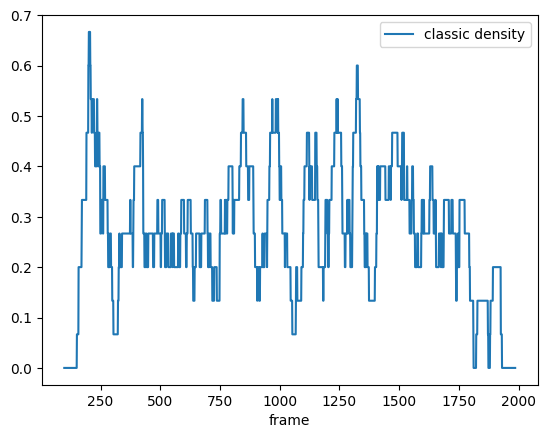

In [15]:
classic_density.reset_index().plot.line(x="frame", y="classic density")

## Voronoi density

### Compute individual Voronoi Polygons

#### Without cut-off

In [7]:
from pedpy import compute_individual_voronoi_polygons

individual = compute_individual_voronoi_polygons(
    traj_data=traj.data, geometry=geometry
)
individual

,ID,frame,individual voronoi,individual density
0,1,98,"POLYGON ((10 -3, -10 -3, -10 8, 10 8, 10 -3), ...",0.006757
1,1,99,"POLYGON ((10 -3, -10 -3, -10 8, 10 8, 10 -3), ...",0.006757
2,1,100,"POLYGON ((10 -3, -10 -3, -10 8, 10 8, 10 -3), ...",0.006757
3,1,101,"POLYGON ((10 -3, -10 -3, -10 8, 10 8, 10 -3), ...",0.006757
4,1,102,"POLYGON ((10 -3, -10 -3, -10 8, 10 8, 10 -3), ...",0.006757
...,...,...,...,...
23436,136,1985,"POLYGON ((-10 1.8857921758201024, -10 4.258199...",0.101571
23579,137,1985,"POLYGON ((-10 4.258199834402812, -10 8, 10 8, ...",0.016006
23705,138,1985,POLYGON ((-1.7001669336399718 2.65183595176017...,0.013214
23580,137,1986,"POLYGON ((-10 2.42860384816381, -10 8, 10 8, 1...",0.014312


#### With cut-off
**Note:** second argument of `cut_off` needs to be divisable by 4!

In [17]:
from pedpy import compute_individual_voronoi_polygons

individual_cutoff = compute_individual_voronoi_polygons(
    traj_data=traj.data, geometry=geometry, cut_off=(1.0, 12)
)

### Compute actual Voronoi density

#### Without cut-off

In [18]:
from pedpy import compute_voronoi_density

density_voronoi, intersecting = compute_voronoi_density(
    individual_voronoi_data=individual, measurement_area=ma
)

<AxesSubplot: xlabel='frame'>

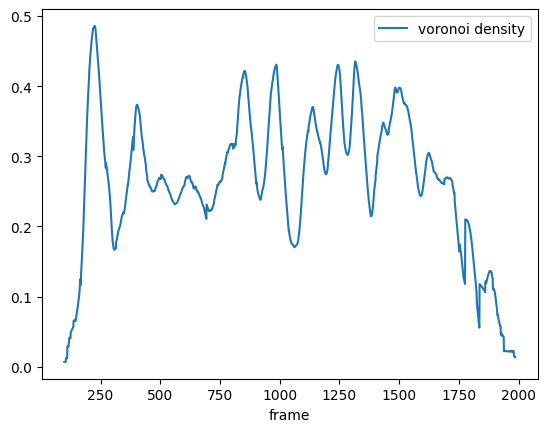

In [19]:
density_voronoi.reset_index().plot.line(x="frame", y="voronoi density")

#### With cut-off

In [20]:
from pedpy import compute_voronoi_density

density_voronoi_cutoff, intersecting_cutoff = compute_voronoi_density(
    individual_voronoi_data=individual_cutoff, measurement_area=ma
)

<AxesSubplot: xlabel='frame'>

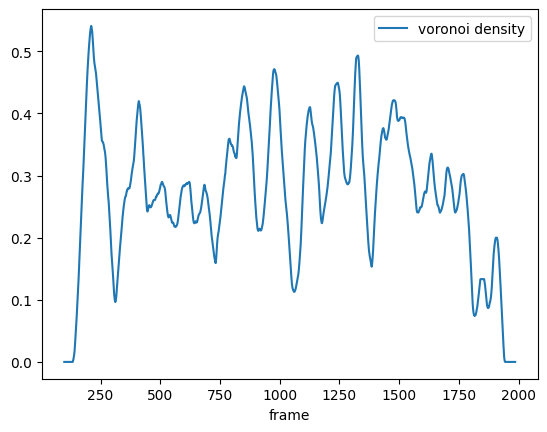

In [21]:
density_voronoi_cutoff.reset_index().plot.line(x="frame", y="voronoi density")

## Comparision

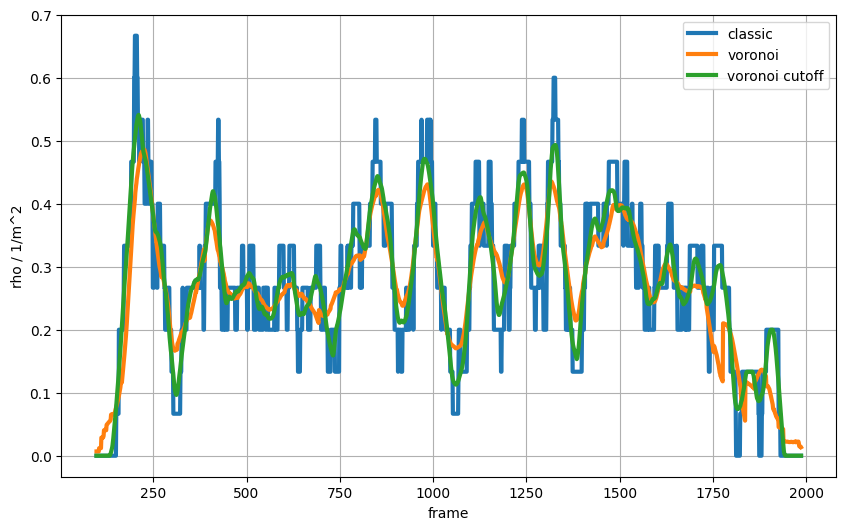

In [22]:
fig = plt.figure(figsize=(10, 6))
plt.plot(
    classic_density.reset_index().frame,
    classic_density["classic density"].values,
    label="classic",
    lw=3,
)
plt.plot(
    density_voronoi.reset_index().frame,
    density_voronoi["voronoi density"],
    label="voronoi",
    lw=3,
)
plt.plot(
    density_voronoi_cutoff.reset_index().frame,
    density_voronoi_cutoff["voronoi density"],
    label="voronoi cutoff",
    lw=3,
)
plt.xlabel("frame")
plt.ylabel("rho / 1/m^2")
plt.legend()
plt.grid()
plt.show()

## Plot voronoi cells

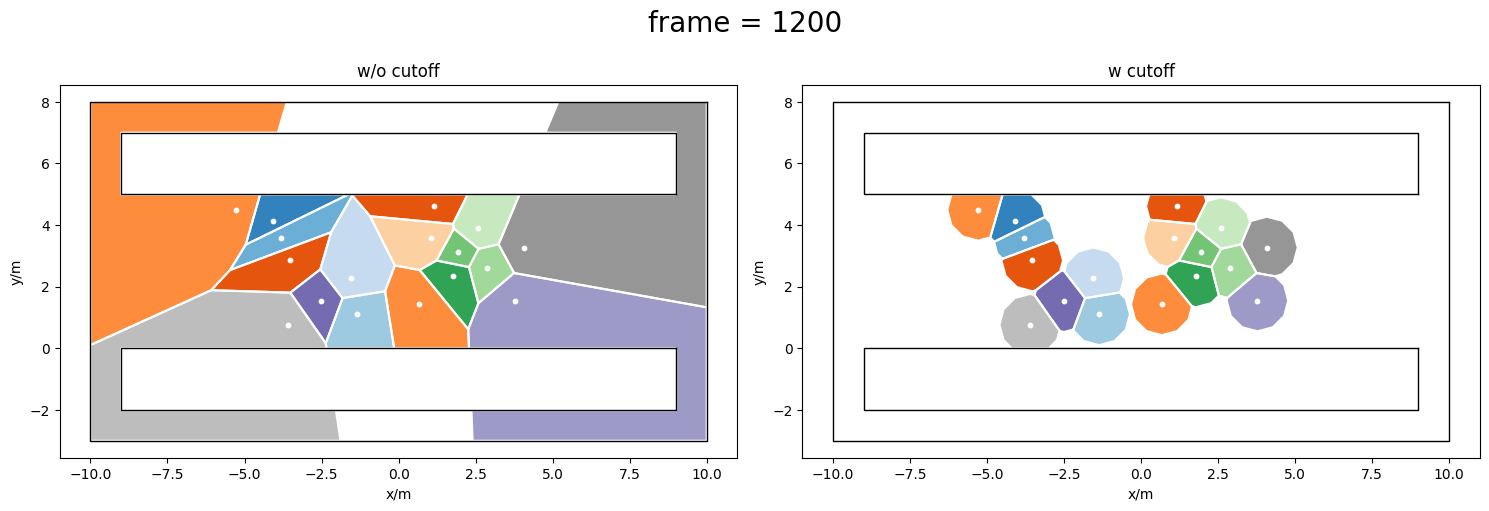

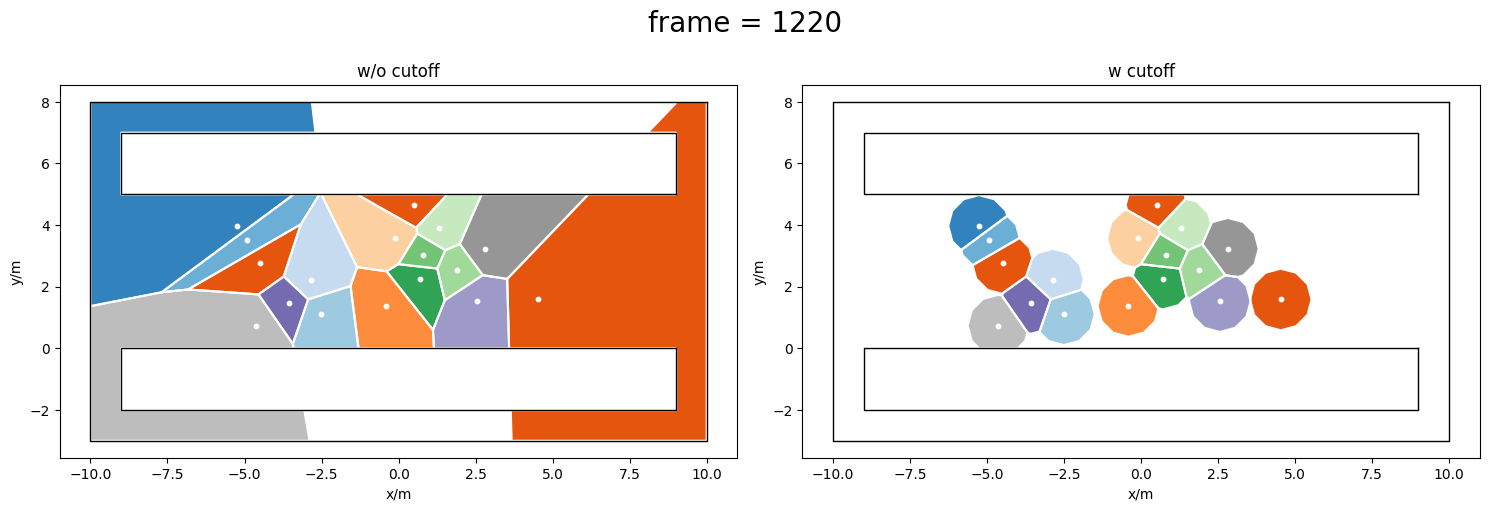

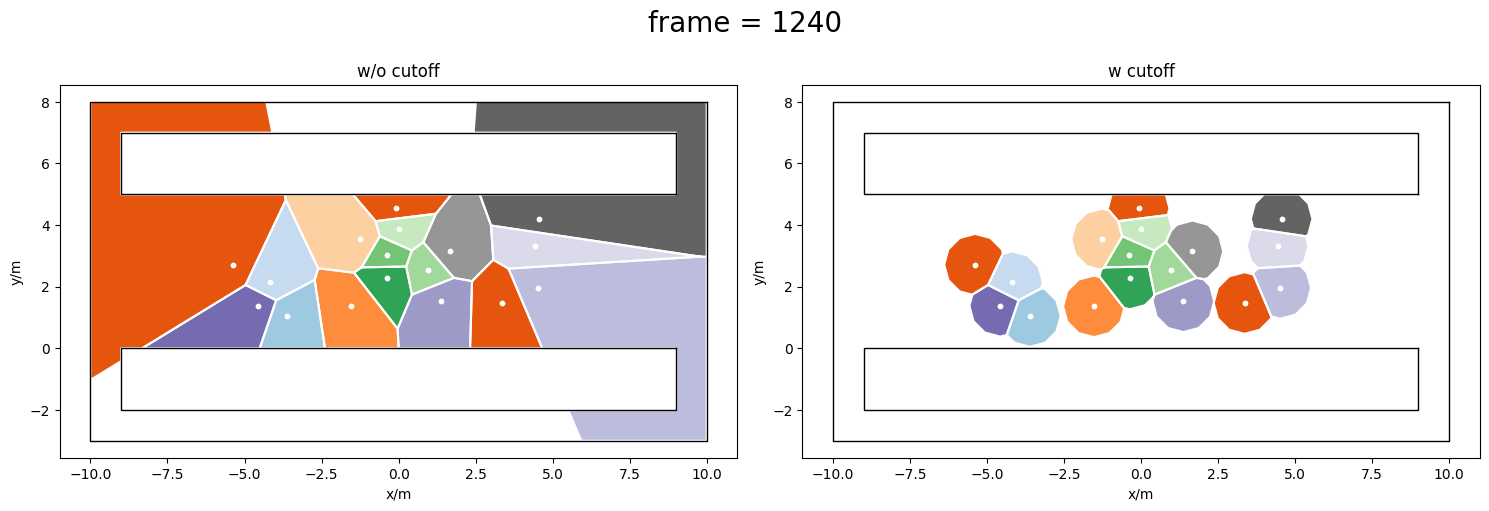

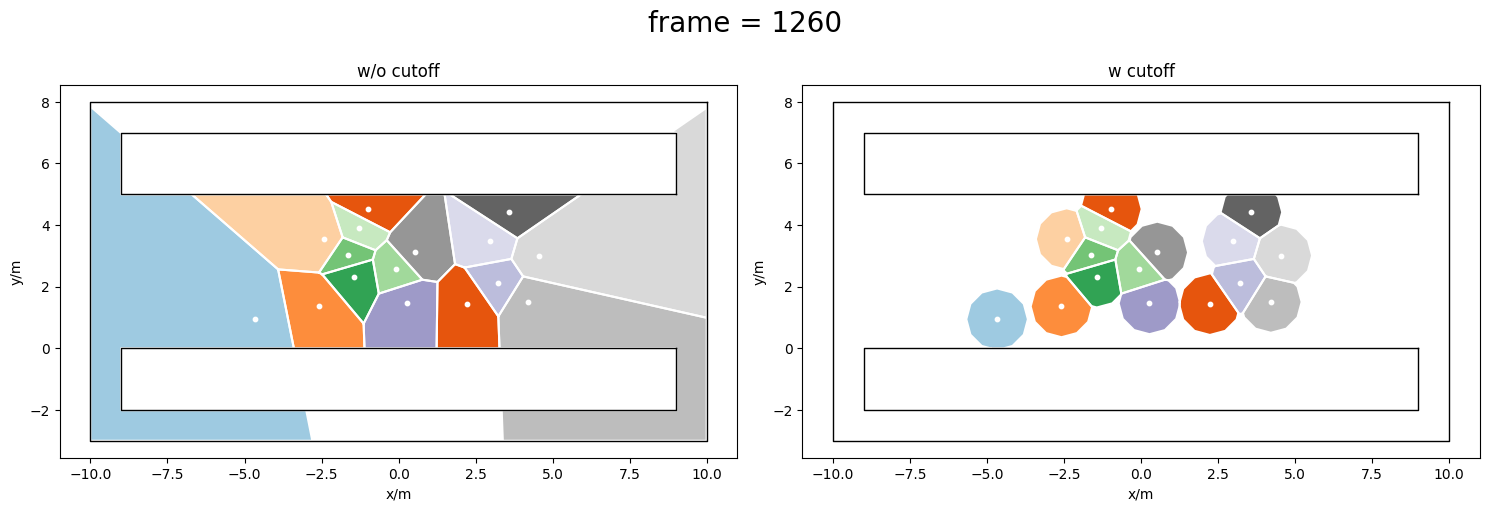

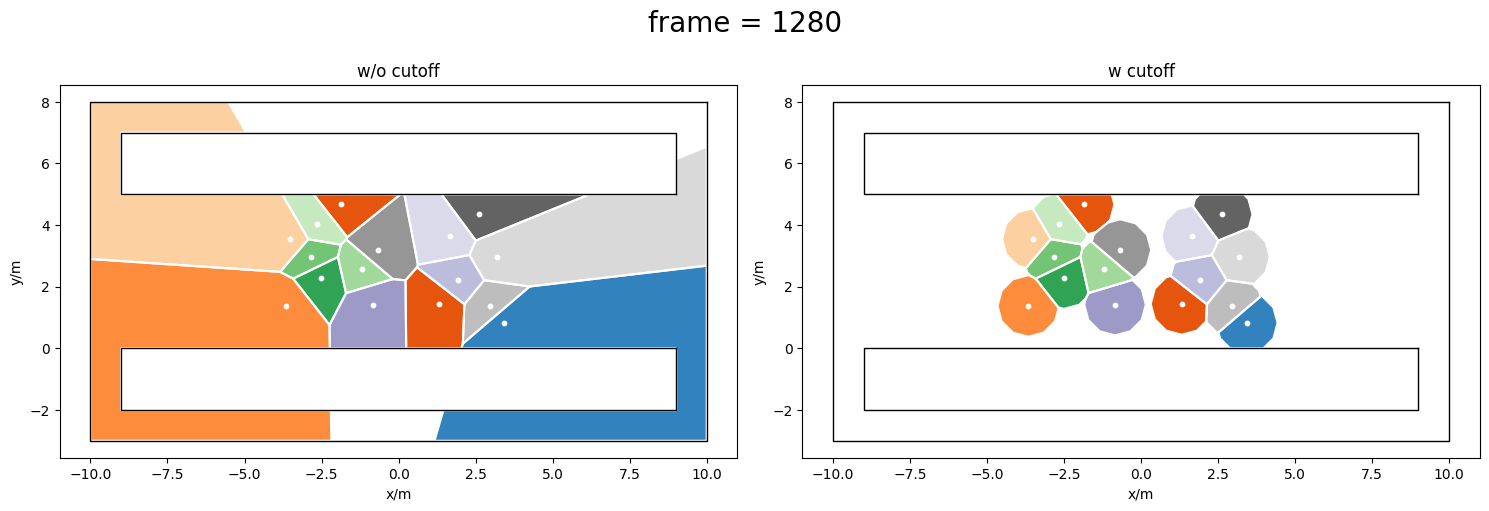

In [23]:
from pedpy import plot_voronoi_cells

frame_start = 1200

for frame in range(frame_start, frame_start + 100, 20):
    fig = plt.figure(f"frame = {frame}", figsize=(15, 20))
    fig.suptitle(f"frame = {frame}", y=0.62, fontsize=20)
    df_frame = intersecting[intersecting.frame == frame]
    df_frame = pd.merge(traj.data, df_frame, on=["ID", "frame"])

    ax1 = fig.add_subplot(121, aspect="equal")
    ax1.set_title("w/o cutoff")
    plot_voronoi_cells(
        data=df_frame,
        geometry=geometry,
        color_mode="id",
        show_ped_positions=True,
        ped_size=10,
        ax=ax1,
    )

    df_frame_cutoff = intersecting_cutoff[intersecting_cutoff.frame == frame]
    df_frame_cutoff = pd.merge(traj.data, df_frame_cutoff, on=["ID", "frame"])

    ax2 = fig.add_subplot(122, aspect="equal")
    ax2.set_title("w cutoff")

    plot_voronoi_cells(
        data=df_frame_cutoff,
        geometry=geometry,
        color_mode="id",
        show_ped_positions=True,
        ped_size=10,
        ax=ax2,
    )

    fig.tight_layout()
    plt.show()

## Passing density (individual)

In [24]:
from pedpy import compute_passing_density
from pedpy import compute_frame_range_in_area

frames_in_area, _ = compute_frame_range_in_area(
    traj_data=traj.data, measurement_line=ml, width=passing_offset
)
passing_density = compute_passing_density(
    density_per_frame=classic_density, frames=frames_in_area
)
passing_density

,ID,density
0,1,0.384127
1,2,0.477778
2,3,0.400000
3,4,0.577778
4,5,0.578947
...,...,...
143,144,0.361905
144,145,0.354386
145,146,0.085185
146,147,0.353333


# Velocity

## Individual speed

In [25]:
from pedpy import compute_individual_velocity

individual_speed = compute_individual_velocity(
    traj_data=traj.data,
    frame_rate=traj.frame_rate,
    frame_step=5,
    x_y_components=True,
)
individual_speed

,ID,frame,speed,v_x,v_y
0,1,98,1.677581,-1.6525,0.2890
1,1,99,1.632689,-1.6085,0.2800
2,1,100,1.457490,-1.4525,0.1205
3,1,101,1.442132,-1.4390,0.0950
4,1,102,1.485936,-1.4825,0.1010
...,...,...,...,...,...
25531,148,872,1.341414,-1.3335,0.1455
25532,148,873,1.353079,-1.3505,0.0835
25533,148,874,1.348107,-1.3480,0.0170
25534,148,875,1.301581,-1.3015,-0.0145


<AxesSubplot: xlabel='frame', ylabel='speed'>

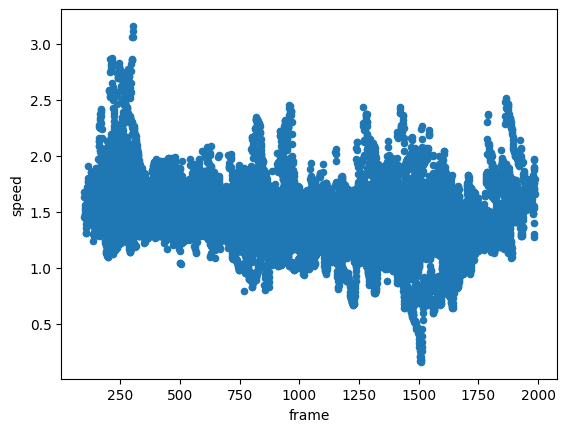

In [26]:
individual_speed.plot.scatter(x="frame", y="speed")

In [27]:
individual_speed_direction = compute_individual_velocity(
    traj_data=traj.data,
    frame_rate=traj.frame_rate,
    frame_step=5,
    movement_direction=direction,
    x_y_components=True,
)
individual_speed_direction

,ID,frame,speed,v_x,v_y
0,1,98,1.6525,-1.6525,0.0
1,1,99,1.6085,-1.6085,0.0
2,1,100,1.4525,-1.4525,0.0
3,1,101,1.4390,-1.4390,0.0
4,1,102,1.4825,-1.4825,0.0
...,...,...,...,...,...
25531,148,872,1.3335,-1.3335,0.0
25532,148,873,1.3505,-1.3505,0.0
25533,148,874,1.3480,-1.3480,0.0
25534,148,875,1.3015,-1.3015,0.0


<AxesSubplot: xlabel='frame', ylabel='speed'>

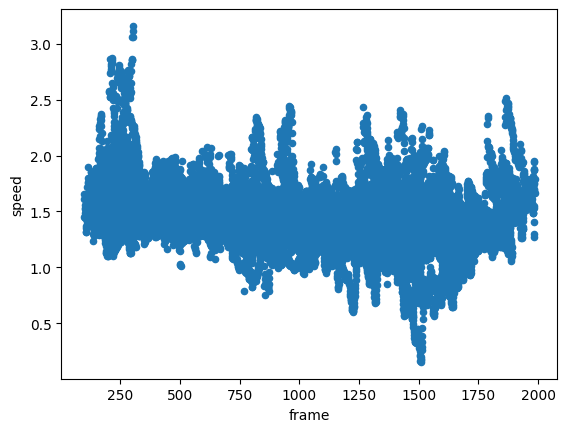

In [28]:
individual_speed_direction.plot.scatter(x="frame", y="speed")

## Mean speed (in measurement area)

In [29]:
from pedpy import compute_mean_velocity_per_frame

mean_speed = compute_mean_velocity_per_frame(
    traj_data=traj.data,
    measurement_area=ma,
    individual_velocity=individual_speed,
)
mean_speed

frame
98      0.0
99      0.0
100     0.0
101     0.0
102     0.0
       ... 
1982    0.0
1983    0.0
1984    0.0
1985    0.0
1986    0.0
Name: speed, Length: 1889, dtype: float64

In [30]:
individual_speed

,ID,frame,speed,v_x,v_y
0,1,98,1.677581,-1.6525,0.2890
1,1,99,1.632689,-1.6085,0.2800
2,1,100,1.457490,-1.4525,0.1205
3,1,101,1.442132,-1.4390,0.0950
4,1,102,1.485936,-1.4825,0.1010
...,...,...,...,...,...
25531,148,872,1.341414,-1.3335,0.1455
25532,148,873,1.353079,-1.3505,0.0835
25533,148,874,1.348107,-1.3480,0.0170
25534,148,875,1.301581,-1.3015,-0.0145


<AxesSubplot: xlabel='frame'>

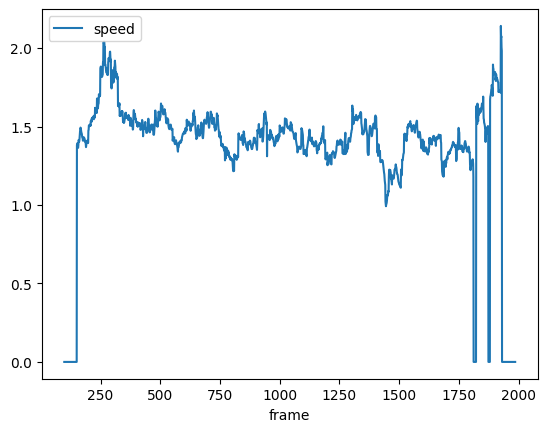

In [31]:
mean_speed.reset_index().plot.line(x="frame", y="speed")

In [32]:
mean_speed_direction = compute_mean_velocity_per_frame(
    traj_data=traj.data,
    measurement_area=ma,
    individual_velocity=individual_speed_direction,
)
mean_speed_direction

frame
98      0.0
99      0.0
100     0.0
101     0.0
102     0.0
       ... 
1982    0.0
1983    0.0
1984    0.0
1985    0.0
1986    0.0
Name: speed, Length: 1889, dtype: float64

## Voronoi speed

In [33]:
from pedpy import compute_voronoi_velocity

In [34]:
individual_voronoi = intersecting.copy(deep=True)

In [35]:
voronoi_velocity = compute_voronoi_velocity(
    traj_data=traj.data,
    individual_voronoi_intersection=individual_voronoi,
    individual_velocity=individual_speed,
    measurement_area=ma,
)
voronoi_velocity

frame
98      1.677581
99      1.632689
100     1.457490
101     1.442132
102     1.485936
          ...   
1982    1.504803
1983    1.507387
1984    1.573675
1985    1.661855
1986    1.735098
Name: voronoi speed, Length: 1889, dtype: float64

<AxesSubplot: xlabel='frame'>

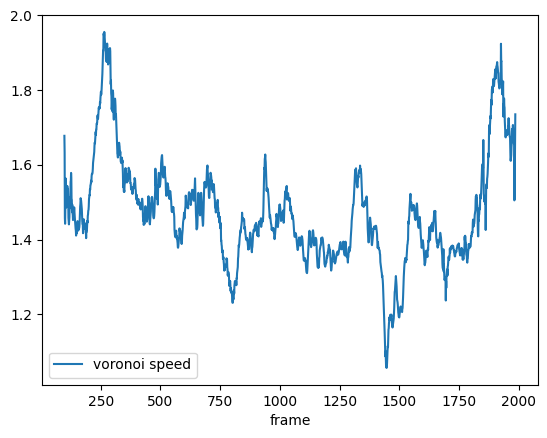

In [36]:
voronoi_velocity.reset_index().plot.line(x="frame", y="voronoi speed")

In [37]:
voronoi_velocity_direction = compute_voronoi_velocity(
    traj_data=traj.data,
    individual_voronoi_intersection=individual_voronoi,
    individual_velocity=individual_speed_direction,
    measurement_area=ma,
)
voronoi_velocity_direction

frame
98      1.652500
99      1.608500
100     1.452500
101     1.439000
102     1.482500
          ...   
1982    1.496894
1983    1.500337
1984    1.565893
1985    1.655297
1986    1.731204
Name: voronoi speed, Length: 1889, dtype: float64

## Comparison mean velocity vs voronoi velocity

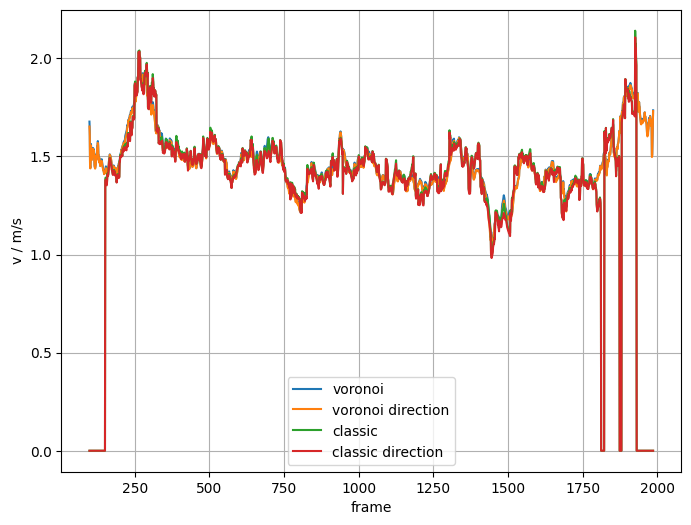

In [38]:
fig = plt.figure(figsize=(8, 6))
plt.plot(
    voronoi_velocity.reset_index().frame, voronoi_velocity, label="voronoi"
)
plt.plot(
    voronoi_velocity_direction.reset_index().frame,
    voronoi_velocity_direction,
    label="voronoi direction",
)
plt.plot(mean_speed.reset_index().frame, mean_speed, label="classic")
plt.plot(
    mean_speed_direction.reset_index().frame,
    mean_speed_direction,
    label="classic direction",
)
plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.legend()
plt.grid()
plt.show()

## Passing speed (individual)

In [39]:
from pedpy import compute_passing_speed
from pedpy import compute_frame_range_in_area

frames_in_area, _ = compute_frame_range_in_area(
    traj_data=traj.data, measurement_line=ml, width=passing_offset
)
passing_speed = compute_passing_speed(
    frames_in_area=frames_in_area,
    frame_rate=traj.frame_rate,
    distance=passing_offset,
)
passing_speed

,ID,speed
0,1,1.190476
1,2,1.388889
2,3,1.562500
3,4,1.388889
4,5,1.315789
...,...,...
143,144,1.190476
144,145,1.315789
145,146,1.388889
146,147,1.250000


# Flow

## N-t diagram

In [40]:
from pedpy import compute_n_t

nt, crossing = compute_n_t(
    traj_data=traj.data, measurement_line=ml, frame_rate=traj.frame_rate
)

<AxesSubplot: xlabel='Time [s]'>

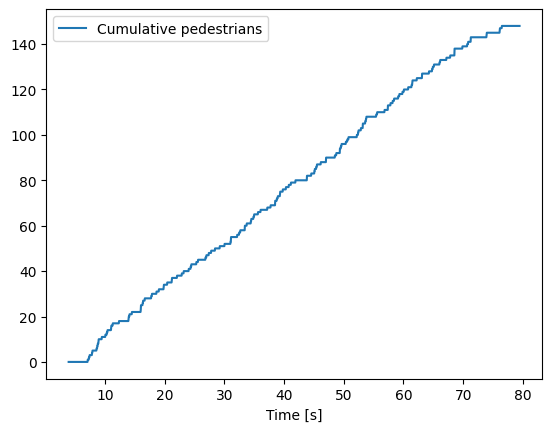

In [41]:
nt.plot(x="Time [s]")

## Flow

In [42]:
from pedpy import compute_flow

delta_t = 100
flow = compute_flow(
    nt=nt,
    crossing_frames=crossing,
    individual_speed=individual_speed,
    delta_t=delta_t,
    frame_rate=traj.frame_rate,
)
flow

,Flow rate(1/s),Mean velocity(m/s)
0,4.000000,1.665072
1,1.744186,1.629261
2,2.212389,1.510628
3,1.822917,1.510923
4,1.941748,1.509915
5,1.941748,1.461630
6,2.577320,1.413225
7,2.020202,1.454108
8,2.364865,1.476358
9,1.953125,1.413156


# Neighborhood

In [43]:
from pedpy import compute_neighbors

neighbors = compute_neighbors(individual_cutoff)
neighbors

,ID,frame,neighbors
0,1,98,[]
0,1,99,[]
0,1,100,[]
0,1,101,[]
0,1,102,[]
...,...,...,...
0,136,1985,"[137, 138]"
1,137,1985,[136]
2,138,1985,[136]
0,137,1986,[]


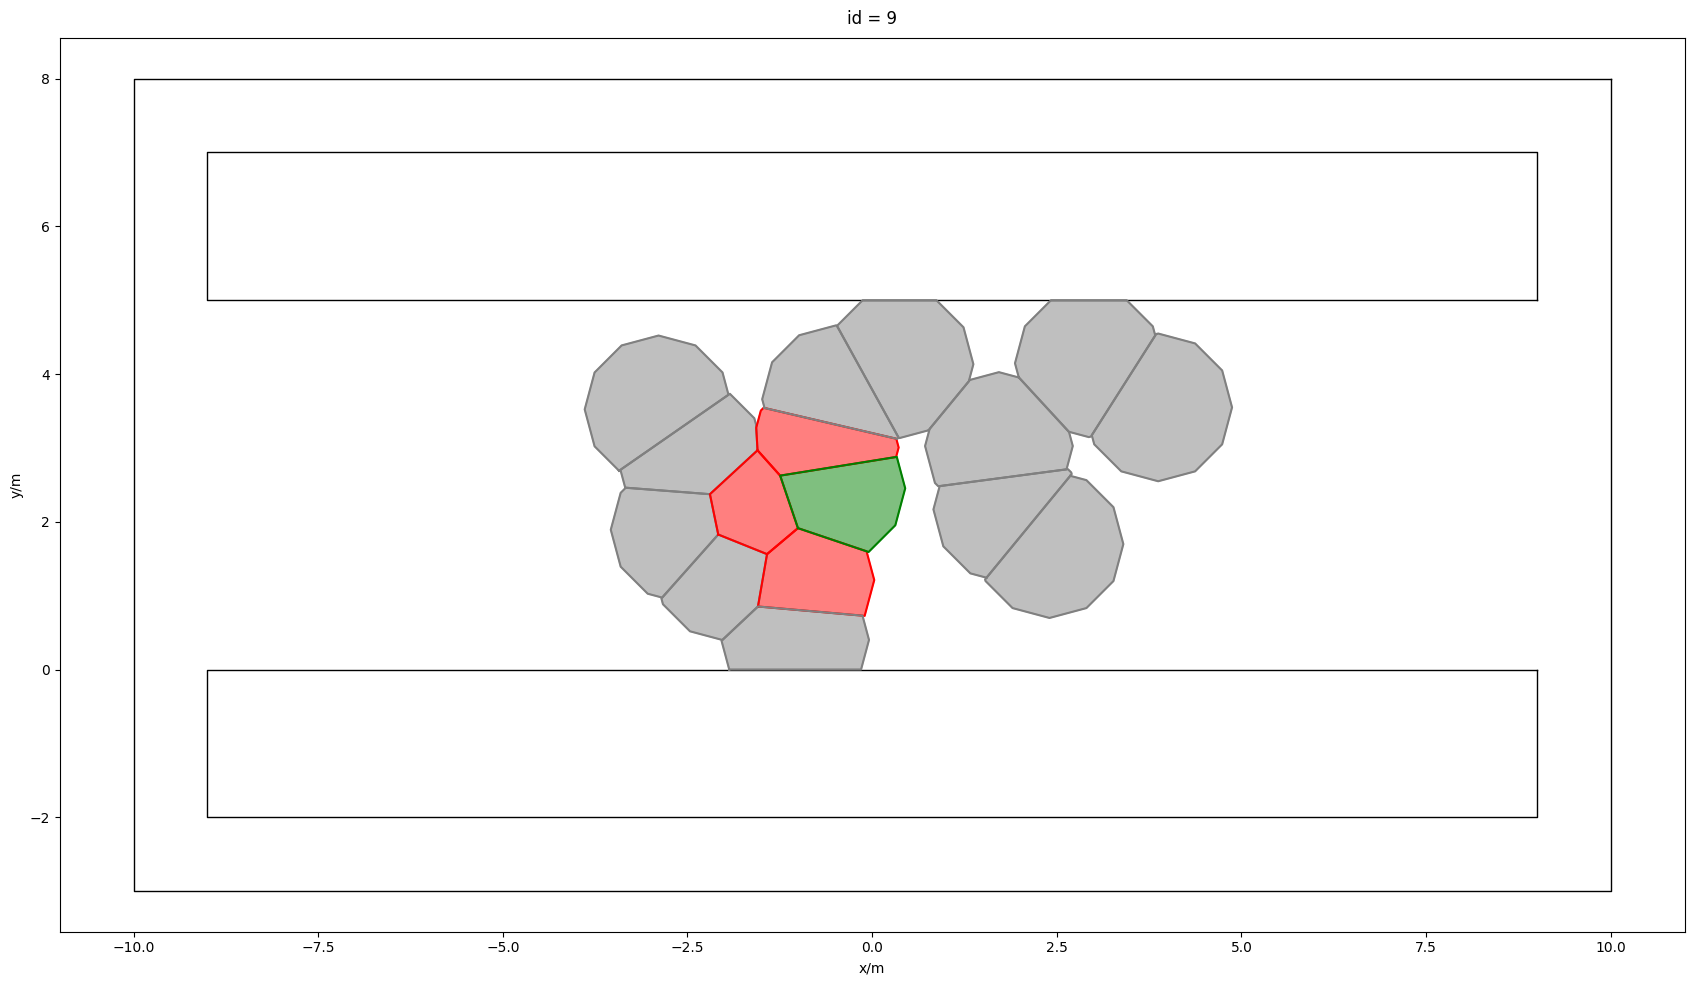

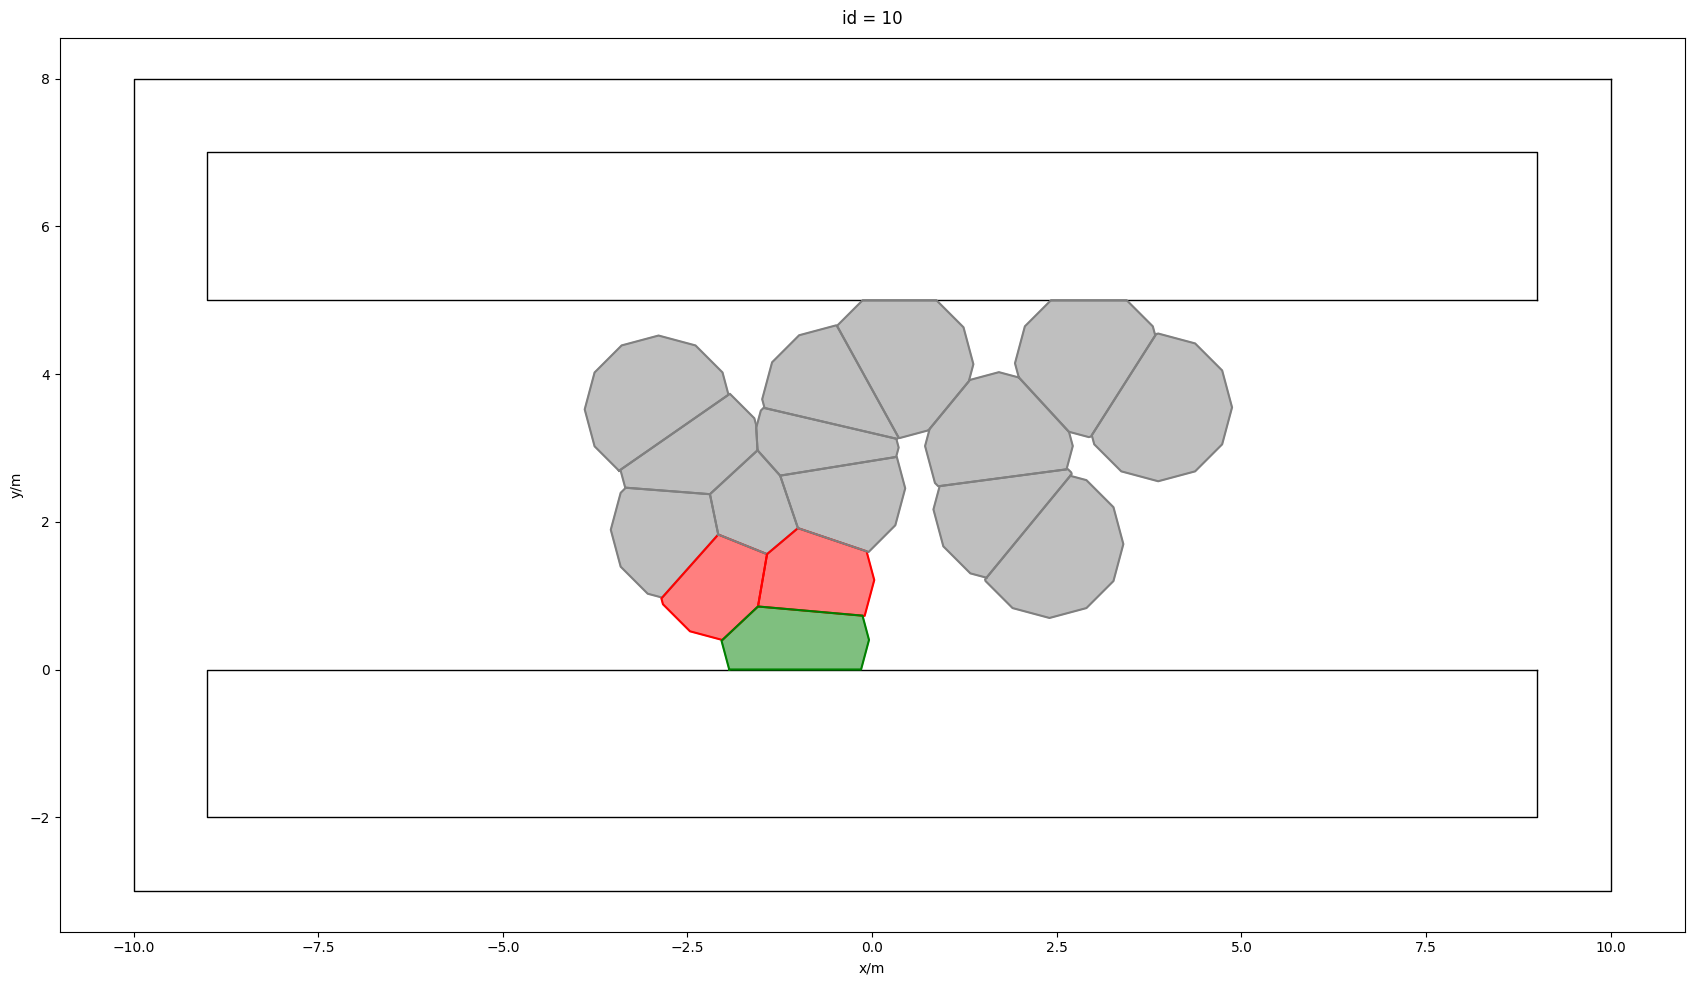

In [44]:
frame = 231

voronoi_neighbors = pd.merge(
    individual_cutoff[individual_cutoff.frame == frame],
    neighbors[neighbors.frame == frame],
    on=["ID", "frame"],
)

for base in voronoi_neighbors["ID"].values[8:10]:
    base_neighbors = voronoi_neighbors[voronoi_neighbors["ID"] == base][
        "neighbors"
    ].values[0]

    fig = plt.figure(f"frame = {frame}", figsize=(20, 10))

    ax = fig.add_subplot(111, aspect="equal")
    fig.suptitle(f"id = {base}")
    plot_geometry(ax=ax, geometry=geometry)

    for _, row in voronoi_neighbors.iterrows():
        poly = row["individual voronoi"]
        ped_id = row["ID"]

        are_neighbors = ped_id in base_neighbors

        color = "gray"
        if ped_id == base:
            color = "green"

        if are_neighbors:
            color = "red"

        ax.plot(*poly.exterior.xy, alpha=1, color=color)
        ax.fill(*poly.exterior.xy, alpha=0.5, color=color)

    fig.tight_layout()
    plt.show()

# Profiles

In [45]:
from pedpy import (
    compute_profiles,
    compute_individual_voronoi_polygons,
    compute_individual_velocity,
    VelocityMethod,
)

In [46]:
min_frame_profiles = 900
max_frame_profiles = 1000

frames_data = traj.data[
    traj.data.frame.isin(range(min_frame_profiles, max_frame_profiles))
]

individual_frames = compute_individual_voronoi_polygons(
    traj_data=frames_data,
    geometry=geometry,
    cut_off=(0.8, 12),
)

individual_speed = compute_individual_velocity(
    traj_data=frames_data,
    frame_rate=traj.frame_rate,
    frame_step=5,
)

In [47]:
density_profiles, velocity_profiles = compute_profiles(
    individual_voronoi_velocity_data=pd.merge(
        individual_frames, individual_speed, on=["ID", "frame"]
    ),
    walkable_area=geometry.walkable_area,
    grid_size=0.2,
    velocity_method=VelocityMethod.VORONOI,
)

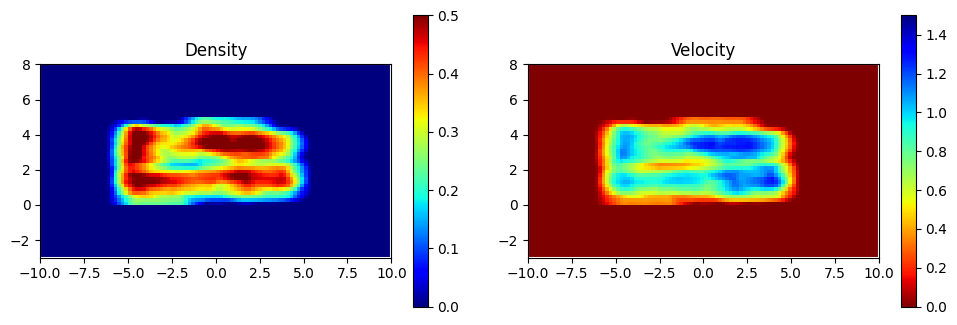

In [48]:
import matplotlib.pyplot as plt
import numpy as np

bounds = geometry.walkable_area.bounds

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

ax0.set_title("Density")
cm = ax0.imshow(
    np.mean(density_profiles, axis=0),
    extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
    interpolation="None",
    cmap="jet",
    vmin=0,
    vmax=0.5,
)
fig.colorbar(cm, ax=ax0, shrink=0.3)
ax0.plot(*geometry.walkable_area.exterior.xy, color="w")

ax1.set_title("Velocity")
cm = ax1.imshow(
    np.mean(velocity_profiles, axis=0),
    extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
    cmap="jet_r",
    vmin=0,
    vmax=1.5,
)
fig.colorbar(cm, ax=ax1, shrink=0.3)

ax1.plot(*geometry.walkable_area.exterior.xy, color="w")

fig.tight_layout()

# What to do with the results?

## Combine multiple DataFrames


In [49]:
traj.data

,ID,frame,X,Y,Z,points
0,1,98,4.6012,1.8909,1.76,POINT (4.6012 1.8909)
1,1,99,4.5359,1.8976,1.76,POINT (4.5359 1.8976)
2,1,100,4.4470,1.9304,1.76,POINT (4.447 1.9304)
3,1,101,4.3865,1.9364,1.76,POINT (4.3865 1.9364)
4,1,102,4.3285,1.9452,1.76,POINT (4.3285 1.9452)
...,...,...,...,...,...,...
25531,148,872,-5.1631,1.4840,1.76,POINT (-5.1631 1.484)
25532,148,873,-5.2162,1.4826,1.76,POINT (-5.2162 1.4826)
25533,148,874,-5.2685,1.4796,1.76,POINT (-5.2685 1.4796)
25534,148,875,-5.3164,1.4793,1.76,POINT (-5.3164 1.4793)


In [50]:
individual

,ID,frame,individual voronoi
0,1,98,"POLYGON ((10 -3, -10 -3, -10 8, 10 8, 10 -3), ..."
1,1,99,"POLYGON ((10 -3, -10 -3, -10 8, 10 8, 10 -3), ..."
2,1,100,"POLYGON ((10 -3, -10 -3, -10 8, 10 8, 10 -3), ..."
3,1,101,"POLYGON ((10 -3, -10 -3, -10 8, 10 8, 10 -3), ..."
4,1,102,"POLYGON ((10 -3, -10 -3, -10 8, 10 8, 10 -3), ..."
...,...,...,...
23436,136,1985,"POLYGON ((-10 1.8857921758201024, -10 4.258199..."
23579,137,1985,"POLYGON ((-10 4.258199834402812, -10 8, 10 8, ..."
23705,138,1985,POLYGON ((-1.7001669336399718 2.65183595176017...
23580,137,1986,"POLYGON ((-10 2.42860384816381, -10 8, 10 8, 1..."


In [51]:
data_with_voronoi_cells = traj.data.merge(intersecting, on=["ID", "frame"])
data_with_voronoi_cells

,ID,frame,X,Y,Z,points,individual voronoi,intersection voronoi
0,1,98,4.6012,1.8909,1.76,POINT (4.6012 1.8909),"POLYGON ((10 -3, -10 -3, -10 8, 10 8, 10 -3), ...","POLYGON ((-1.5 0, -1.5 5, 1.5 5, 1.5 0, -1.5 0))"
1,1,99,4.5359,1.8976,1.76,POINT (4.5359 1.8976),"POLYGON ((10 -3, -10 -3, -10 8, 10 8, 10 -3), ...","POLYGON ((-1.5 0, -1.5 5, 1.5 5, 1.5 0, -1.5 0))"
2,1,100,4.4470,1.9304,1.76,POINT (4.447 1.9304),"POLYGON ((10 -3, -10 -3, -10 8, 10 8, 10 -3), ...","POLYGON ((-1.5 0, -1.5 5, 1.5 5, 1.5 0, -1.5 0))"
3,1,101,4.3865,1.9364,1.76,POINT (4.3865 1.9364),"POLYGON ((10 -3, -10 -3, -10 8, 10 8, 10 -3), ...","POLYGON ((-1.5 0, -1.5 5, 1.5 5, 1.5 0, -1.5 0))"
4,1,102,4.3285,1.9452,1.76,POINT (4.3285 1.9452),"POLYGON ((10 -3, -10 -3, -10 8, 10 8, 10 -3), ...","POLYGON ((-1.5 0, -1.5 5, 1.5 5, 1.5 0, -1.5 0))"
...,...,...,...,...,...,...,...,...
25531,148,872,-5.1631,1.4840,1.76,POINT (-5.1631 1.484),POLYGON ((-3.666732896559221 1.156925965287808...,POLYGON EMPTY
25532,148,873,-5.2162,1.4826,1.76,POINT (-5.2162 1.4826),POLYGON ((-3.7086534851365576 1.13149275997602...,POLYGON EMPTY
25533,148,874,-5.2685,1.4796,1.76,POINT (-5.2685 1.4796),"POLYGON ((-10 1.5292533776595718, -10 3.954348...",POLYGON EMPTY
25534,148,875,-5.3164,1.4793,1.76,POINT (-5.3164 1.4793),"POLYGON ((-10 1.634259010756479, -10 3.8559561...",POLYGON EMPTY


In [52]:
data_with_voronoi_cells_speed = data_with_voronoi_cells.merge(
    individual_speed[["ID", "frame", "speed"]], on=["ID", "frame"]
)
data_with_voronoi_cells_speed

,ID,frame,X,Y,Z,points,individual voronoi,intersection voronoi,speed
0,56,900,-2.9854,1.9288,1.76,POINT (-2.9854 1.9288),POLYGON ((-3.6099598792567735 1.81534209781441...,POLYGON EMPTY,1.300364
1,56,901,-3.0356,1.9431,1.76,POINT (-3.0356 1.9431),POLYGON ((-3.6597182063629115 1.81610611702073...,POLYGON EMPTY,1.295794
2,56,902,-3.0859,1.9573,1.76,POINT (-3.0859 1.9573),POLYGON ((-3.711682104586911 1.818638568783472...,POLYGON EMPTY,1.308674
3,56,903,-3.1361,1.9689,1.76,POINT (-3.1361 1.9689),POLYGON ((-3.7596479051497163 1.81739947771944...,POLYGON EMPTY,1.327039
4,56,904,-3.1862,1.9806,1.76,POINT (-3.1862 1.9806),POLYGON ((-3.813842455197297 1.821394852618665...,POLYGON EMPTY,1.311258
...,...,...,...,...,...,...,...,...,...
1676,147,932,-5.2567,4.0638,1.76,POINT (-5.2567 4.0638),POLYGON ((-4.632391537789299 3.203978487454379...,POLYGON EMPTY,1.150984
1677,147,933,-5.3039,4.0683,1.76,POINT (-5.3039 4.0683),POLYGON ((-4.6947429511166225 3.19103095365396...,POLYGON EMPTY,1.187635
1678,147,934,-5.3524,4.0688,1.76,POINT (-5.3524 4.0688),POLYGON ((-4.746389971025362 3.199131745861873...,POLYGON EMPTY,1.225534
1679,147,935,-5.3971,4.0657,1.76,POINT (-5.3971 4.0657),"POLYGON ((-4.790466050088694 3.19876442975589,...",POLYGON EMPTY,1.201342


## Save in files

### Create directories to store the results

In [53]:
pathlib.Path("results_introduction/profiles/velocity").mkdir(
    parents=True, exist_ok=True
)
pathlib.Path("results_introduction/profiles/density").mkdir(
    parents=True, exist_ok=True
)

results_directory = pathlib.Path("results_introduction")

### Save Pandas dataframe (result from everything but profiles) as csv

In [54]:
import csv

data_with_voronoi_cells_speed["individual density"] = shapely.area(
    data_with_voronoi_cells_speed["individual voronoi"]
)

with open(
    results_directory / "individual_result.csv", "w"
) as individual_output_file:
    individual_output_file.write(f"#framerate:	{traj.frame_rate}\n\n")
    data_with_voronoi_cells_speed[
        [
            "ID",
            "frame",
            "X",
            "Y",
            "Z",
            "individual density",
            "speed",
            "individual voronoi",
            "intersection voronoi",
        ]
    ].to_csv(
        individual_output_file,
        mode="a",
        header=True,
        sep="\t",
        index_label=False,
        index=False,
        quoting=csv.QUOTE_NONNUMERIC,
    )

### Save numpy arrays (result from profiles) as txt

In [55]:
results_directory_density = results_directory / "profiles/density"
results_directory_velocity = results_directory / "profiles/velocity"

for i in range(len(range(min_frame_profiles, min_frame_profiles + 10))):
    frame = min_frame_profiles + i
    np.savetxt(
        results_directory_density / f"density_frame_{frame:05d}.txt",
        density_profiles[i],
    )
    np.savetxt(
        results_directory_velocity / f"velocity_frame_{frame:05d}.txt",
        velocity_profiles[i],
    )